In [43]:
import nltk
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu, modified_precision
from nltk.metrics import scores
%matplotlib inline

In [2]:
from nmt_run import *

translating es to en
callhome es-en configuration
--------------------------------------------------
loading info_dict from=./callhome_fbank_out/info.dict


 35%|███▌      | 49099/138708 [00:00<00:00, 490985.79it/s]

--------------------------------------------------
creating buckets for: fisher_dev
creating buckets for key: sp
creating buckets for: fisher_dev2
creating buckets for key: sp
creating buckets for: fisher_test
creating buckets for key: sp
creating buckets for: fisher_train
creating buckets for key: sp


100%|██████████| 14284/14284 [00:00<00:00, 641299.03it/s]


creating buckets for: callhome_devtest
creating buckets for key: sp
creating buckets for: callhome_evltest
creating buckets for key: sp
creating buckets for: callhome_train
creating buckets for key: sp
--------------------------------------------------
saving info dict in: ./callhome_fbank_out/buckets_sp.dict
all done ...
--------------------------------------------------
showing buckets for category: fisher_dev
number of buckets=20, width of each bucket=96
index | width | num   
    0 |     0 |    428
    1 |    96 |    978
    2 |   192 |    566
    3 |   288 |    459
    4 |   384 |    337
    5 |   480 |    233
    6 |   576 |    230
    7 |   672 |    179
    8 |   768 |    149
    9 |   864 |    142
   10 |   960 |     79
   11 |  1056 |     85
   12 |  1152 |     45
   13 |  1248 |     28
   14 |  1344 |     24
   15 |  1440 |      7
   16 |  1536 |      5
   17 |  1632 |      1
   18 |  1728 |      1
   19 |  1824 |      1
--------------------------------------------------
show

/afs/inf.ed.ac.uk/group/project/lowres/work/anaconda3/envs/chainer2/lib/python3.6/site-packages/chainer/utils/experimental.py:104: FutureWarning: chainer.links.normalization.layer_normalization.py is experimental. The interface can change in the future.
  FutureWarning)


using ADAM optimizer


In [26]:
model_files = [f for f in os.listdir(os.path.dirname(model_fil))
                   if os.path.basename(model_fil).replace('.model','') in f]
print(model_files)

['seq2seq_sen-138819_hwy0-dec3_emb-64-h-256__sp_en_w_gru_drpt-0.2_noise-0_l2-0_32_32_2_2_2DCNN_BN_LN_enc-3_5.model', 'seq2seq_sen-138819_hwy0-dec3_emb-64-h-256__sp_en_w_gru_drpt-0.2_noise-0_l2-0_32_32_2_2_2DCNN_BN_LN_enc-3_10.model']


In [27]:
max_model_fil = max(model_files, key=lambda s: int(s.split('_')[-1].split('.')[0]))

In [28]:
max_model_fil

'seq2seq_sen-138819_hwy0-dec3_emb-64-h-256__sp_en_w_gru_drpt-0.2_noise-0_l2-0_32_32_2_2_2DCNN_BN_LN_enc-3_10.model'

In [29]:
last_epoch = check_model()

--------------------------------------------------------------------------------
model found = 
callhome_fbank/seq2seq_sen-138819_hwy0-dec3_emb-64-h-256__sp_en_w_gru_drpt-0.2_noise-0_l2-0_32_32_2_2_2DCNN_BN_LN_enc-3_10.model
loading ...
finished loading ..


In [30]:
log_dev_fil_name

'callhome_fbank/dev_sen-138819_hwy0-dec3_emb-64-h-256__sp_en_w_gru_drpt-0.2_noise-0_l2-0_32_32_2_2_2DCNN_BN_LN_enc-3.log'

In [34]:
log_train = np.loadtxt(log_train_fil_name, delimiter=',', skiprows=False).transpose()
log_test = np.loadtxt(log_dev_fil_name, delimiter=',', skiprows=0).transpose()

In [35]:
log_test

array([[  1.    ,   2.    ,   3.    ,   4.    ,   5.    ,   6.    ,
          7.    ,   8.    ,   9.    ,  10.    ],
       [  2.8316,   2.8529,   3.1477,   3.2717,   3.322 ,   3.2819,
          3.3736,   3.5241,   3.4948,   3.5376],
       [  0.0466,   0.1342,   0.1887,   0.137 ,   0.1154,   0.1304,
          0.0856,   0.1104,   0.1245,   0.1316]])

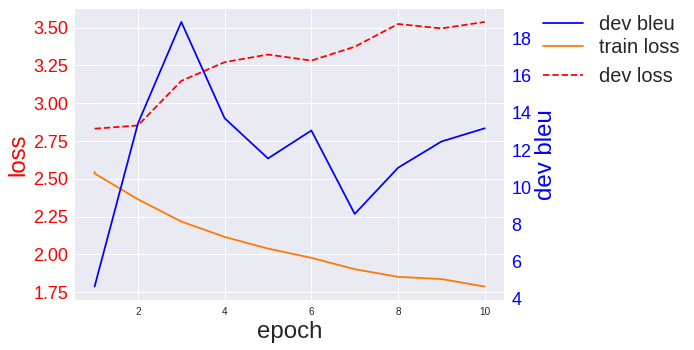

In [36]:
fig, ax1 = plt.subplots()
fig.set_size_inches(8,5)
ax1.plot(log_train[0], log_train[1], color='#ff7700')
ax1.plot(log_test[0], log_test[1], 'r--')
ax1.set_xlabel('epoch', size=24)
ax1.set_ylabel('loss', color='r', size=24)
for tl in ax1.get_yticklabels():
    tl.set_color('r')
    tl.set_fontsize(18)
plt.legend(['train loss', 'dev loss'], bbox_to_anchor=(1.45, 0.96), framealpha=0, fontsize=20)    
ax2 = ax1.twinx()
ax2.plot(log_test[0], log_test[2]*100, 'b-')
ax2.set_xlabel('iteration')
ax2.set_ylabel('dev bleu', color='b', size=24)
# ax2.set_ylim(0, 0.9)
for tl in ax2.get_yticklabels():
    tl.set_color('b')
    tl.set_fontsize(18) 
plt.legend(['dev bleu'], bbox_to_anchor=(1.44, 1.04), framealpha=0, fontsize=20)
plt.grid(False)
plt.tight_layout()

In [37]:
key='callhome_devtest'
train=False
m_dict = map_dict[key]
v_dict = vocab_dict[dec_key]
n=len(map_dict[key])

In [38]:
cat_speech_path = os.path.join(out_path, key)

In [39]:
print("-"*80)
print("EPOCH = {0:d}".format(last_epoch+1))
pred_sents, utts, loss = feed_model(map_dict[key],
                  b_dict=bucket_dict[key],
                  vocab_dict=vocab_dict,
                  batch_size=BATCH_SIZE,
                  x_key=enc_key,
                  y_key=dec_key,
                  train=train,
                  cat_speech_path=cat_speech_path, use_y=True)

print("{0:s} {1:s} mean loss={2:.4f}".format("*" * 10,
                                    "train" if train else "dev",
                                    loss))
print("-")
print("-"*80)

  0%|          | 0/3801 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
EPOCH = 11


b=13,l=5.17,avg=3.54: 100%|██████████| 3801/3801 [02:12<00:00, 10.46it/s]

********** dev mean loss=3.5391
-
--------------------------------------------------------------------------------


In [40]:
display_words(m_dict, v_dict, pred_sents[-50:], utts[-50:], dec_key)

Utterance: sp_1882-B-31
+---------+-------+
| es ref  | ya    |
+---------+-------+
| en ref  | right |
+---------+-------+
| en pred | okay  |
+---------+-------+
Utterance: sp_1805-B-25
+---------+-------+
| es ref  | claro |
+---------+-------+
| en ref  | right |
+---------+-------+
| en pred | okay  |
+---------+-------+
Utterance: sp_1808-B-38
+---------+-----+
| es ref  | mmm |
+---------+-----+
| en ref  | mm  |
+---------+-----+
| en pred | yes |
+---------+-----+
Utterance: sp_1552-B-66
+---------+-----+
| es ref  | sí  |
+---------+-----+
| en ref  | yes |
+---------+-----+
| en pred | yes |
+---------+-----+
Utterance: sp_1947-A-12
+---------+-------+
| es ref  | claro |
+---------+-------+
| en ref  | sure  |
+---------+-------+
| en pred | sure  |
+---------+-------+
Utterance: sp_1292-A-65
+---------+------+
| es ref  | ¡ajá |
+---------+------+
| en ref  | aha  |
+---------+------+
| en pred | sure |
+---------+------+
Utterance: sp_1947-A-61
+---------+---------+
| es 

In [45]:
b, h, r = calc_bleu(m_dict, v_dict, pred_sents[:n], utts[:n], dec_key)

print("BLEU score on: {0:s} = {1:.2f}".format(key, b * 100))

print("-"*60)

all_weights=[(1.,0.,0.,0.),
             (0.,1.,0.,0.),
             (0.,0.,1.,0.),
             (0.,0.,0.,1.),
             (1./2,1./2,0.,0.),
             (1./3,1./3,1./3,0.),
             (.25,.25,.25,.25)]

BLEU score on: callhome_devtest = 13.15
------------------------------------------------------------


/afs/inf.ed.ac.uk/group/project/lowres/work/anaconda3/envs/chainer2/lib/python3.6/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [53]:
import nltk.translate.bleu_score

In [68]:
smooth_fun = nltk.translate.bleu_score.SmoothingFunction()

In [70]:
print("{0:>20s} | {1:20s}".format("bleu score (0-100)", "uni-bi-tri-quad"))
for weights in all_weights:
    b = corpus_bleu(r, h, weights=weights, smoothing_function=smooth_fun.method2)
    print("{0:20.2f} | {1:20s}".format(b * 100, "-".join(map("{0:.2f}".format, weights))))

  bleu score (0-100) | uni-bi-tri-quad     
                7.03 | 1.00-0.00-0.00-0.00 
                0.43 | 0.00-1.00-0.00-0.00 
                0.00 | 0.00-0.00-1.00-0.00 
                0.00 | 0.00-0.00-0.00-1.00 
                1.74 | 0.50-0.50-0.00-0.00 
                0.20 | 0.33-0.33-0.33-0.00 
                0.07 | 0.25-0.25-0.25-0.25 


In [42]:
_, _ = corpus_precision_recall(r, h)

metric     |   1-gram |   2-gram|   3-gram |   4-gram
------------------------------------------------------
precision  |     7.03 |     0.43|     0.00 |     0.00
recall     |    18.13 |     1.33|     0.00 |     0.00


### Test code

In [ ]:
# test_ref = [["ha ha lol hue".split()], ["ha ha ja ha".split()], ["ha ha ja ha".split()]]
# test_h = ["lol ja".split(), "ha he".split(), "ha ja".split()]
# _, _ = corpus_precision_recall(test_ref, test_h)